In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import librosa
import librosa.display
import IPython.display as ipd

from tqdm import tqdm

<br/>
<br/>
<br/>

# UNZIPPING ".tar.gz" FILE

In [ ]:
import tarfile
def unzip_file(zip_file_path,extract_path):
  file = tarfile.open(zip_file_path)
  file.extractall(extract_path)
  file.close()

In [ ]:
zip_file_path = './drive/MyDrive/UrbanSound8K.tar.gz'
extract_path = './drive/MyDrive/UrbanSoundDataset'
#unzip_file(zip_file_path,extract_path)

In [ ]:
os.listdir('./drive/MyDrive/UrbanSoundDataset')

['UrbanSound8K']

<br/>
<br/>
<br/>

# DATA VISUALIZATION

- IPython Display audio player
- time vs amplitude
- FFT
- STFT Spectograms
- Mel Spectograms
- MFCC

In [2]:
metadata_path = './drive/MyDrive/UrbanSoundDataset/UrbanSound8K/metadata/UrbanSound8K.csv'
df = pd.read_csv(metadata_path)
df = df[["slice_file_name","fold","class"]]
df.head(5)

,slice_file_name,fold,class
0,100032-3-0-0.wav,5,dog_bark
1,100263-2-0-117.wav,5,children_playing
2,100263-2-0-121.wav,5,children_playing
3,100263-2-0-126.wav,5,children_playing
4,100263-2-0-137.wav,5,children_playing


#### Categories Visualization

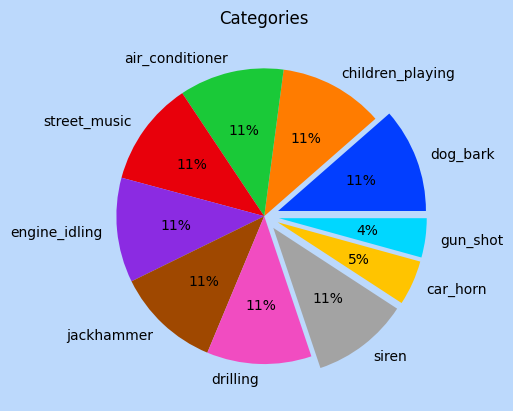

In [3]:
class_names = df["class"].value_counts().index
values = df["class"].value_counts().values
emergency_classes = ["dog_bark","gun_shot","car_horn","siren"]
explode = [ 0 if class_name not in emergency_classes else 0.1 for class_name in class_names ]


palette_color = sns.color_palette('bright')

plt.figure(facecolor="#BCD9FC")
plt.pie(values, labels=class_names, colors=palette_color, explode=explode, autopct='%.0f%%')
plt.title("Categories")
plt.show()

In [4]:
def get_random_file_path(df,random_state=None):
    random_row = df.sample(1,random_state=random_state)
    return [random_row[i].to_numpy()[0] for i in random_row.columns]

In [5]:
class Visualization:
  def __init__(self,file_path,n_mel=128,n_mfcc=13):
    self.file_path = file_path
    self.amplitude = None
    self.sample_rate = None
    self.n_mel = n_mel
    self.n_mfcc = n_mfcc

  def playable_audio(self):
    return ipd.Audio(self.file_path)

  def load_file(self):
    self.amplitude,self.sample_rate = librosa.load(self.file_path)

  def plot_time_vs_amplitude(self):
    xmax = (1/self.sample_rate)*len(self.amplitude)

    plt.figure(figsize=(12,5))
    librosa.display.waveshow(self.amplitude, sr=self.sample_rate)
    plt.hlines(y= 0, xmin= 0, xmax= xmax,linewidth=0.5,color="black")
    plt.ylabel("Amplitude")
    plt.title("Time vs Amplitude")
    plt.show();


  def plot_FFT(self):

    magnitudes = np.fft.fft(self.amplitude)
    magnitudes = np.abs(magnitudes)
    frequencies = np.linspace(0,self.sample_rate,len(magnitudes))

    plt.figure(figsize=(12,5))
    plt.plot(frequencies,magnitudes)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("Frequency Domain Graph by FFT")
    plt.show();


  def stft_spectogram(self):
    stft = librosa.stft(self.amplitude,n_fft=2048, hop_length=512, win_length=2048)
    stft = np.abs(stft)
    img = librosa.display.specshow(librosa.amplitude_to_db(stft,ref=np.max),
                                y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(img, format="%+2.0f dB")
    plt.show();


  def mel_spectogram(self):
    melspect = librosa.feature.melspectrogram(y=self.amplitude , sr=self.sample_rate, n_mels=self.n_mel, n_fft=2048, hop_length=512, win_length=2048)
    log_mel = librosa.power_to_db(melspect, ref=np.max)

    img = librosa.display.specshow(log_mel, x_axis='time',y_axis='mel', sr=self.sample_rate)
    plt.colorbar(img, format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.show();


  def plot_MFCCs(self):
    mfccs = librosa.feature.mfcc(y=self.amplitude,n_mfcc=self.n_mfcc,sr=self.sample_rate,win_length=2048,hop_length=512)
    img = librosa.display.specshow(mfccs,x_axis="time",sr=self.sample_rate)
    plt.colorbar(img, format='%+2.0f dB')
    plt.ylabel("MFCC")
    plt.title("MFCC Plot")
    plt.show();

In [6]:
def visualize(df,random_state=None,n_mel=128,n_mfcc=13):

   [file_name,folder,class_name] = get_random_file_path(df,random_state=random_state)
   audio_file_path = f"/content/drive/MyDrive/UrbanSoundDataset/UrbanSound8K/audio/fold{folder}/{file_name}"

   vis = Visualization(audio_file_path,n_mel,n_mfcc)
   vis.load_file()
   vis.plot_time_vs_amplitude()
   vis.plot_FFT()
   vis.stft_spectogram()
   vis.mel_spectogram()
   vis.plot_MFCCs()
   print("CLASS NAME: ",class_name)
   print()
   print()
   return vis.playable_audio()

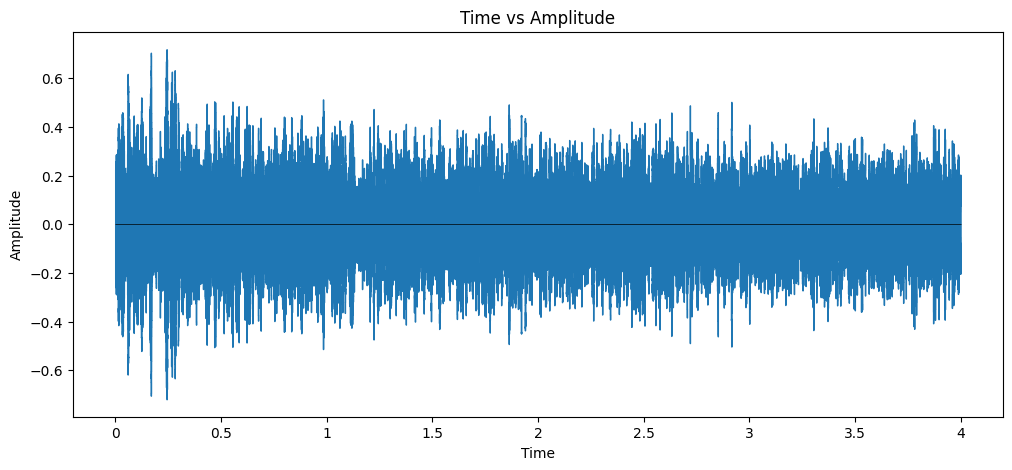

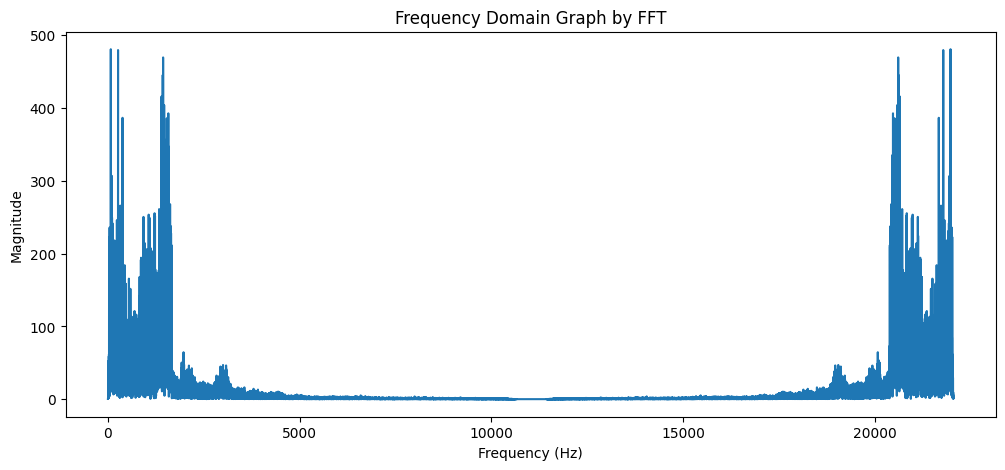

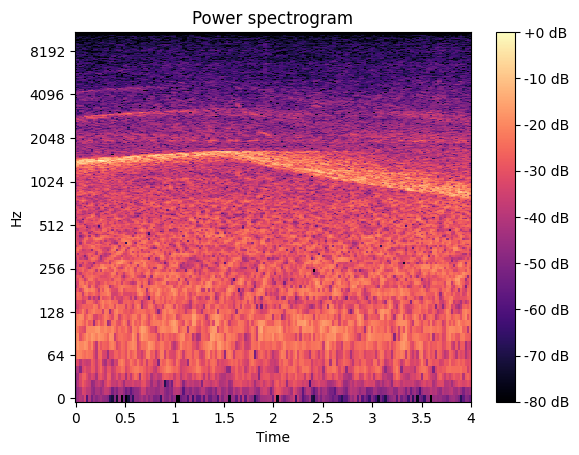

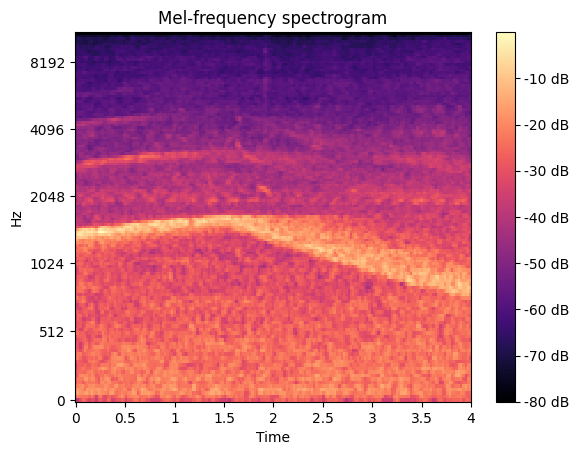

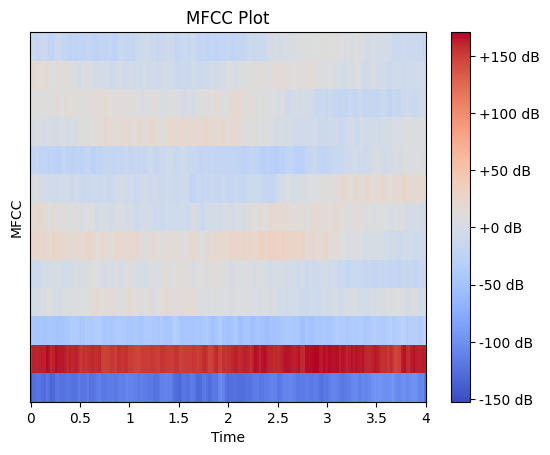

CLASS NAME:  siren




In [7]:
visualize(df)

<br/>
<br/>
<br/>
<br/>

# DATA PREPROCESSING

### TRAIN , TEST , VALIDATION SPLIT

In [12]:
X = df[['slice_file_name',"fold"]]
y = df["class"]
X.shape,y.shape

((8732, 2), (8732,))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42,stratify=y_test)


In [14]:
y_test.value_counts()

children_playing    100
street_music        100
air_conditioner     100
drilling            100
dog_bark            100
engine_idling       100
jackhammer          100
siren                93
car_horn             43
gun_shot             37
Name: class, dtype: int64

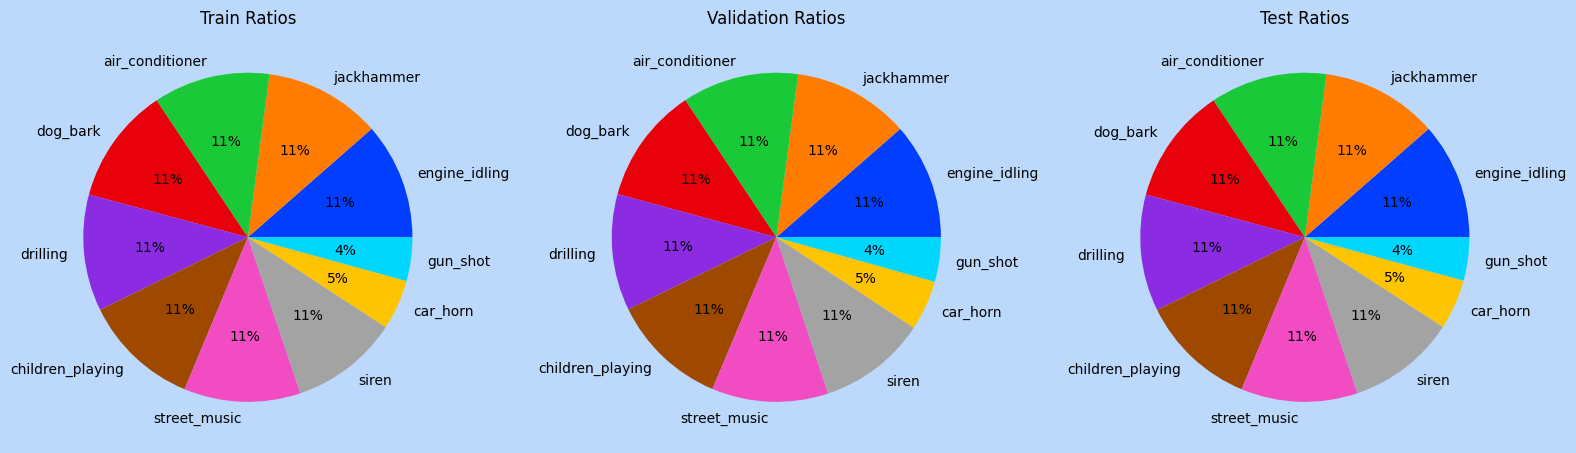

In [15]:
class_names = y_train.value_counts().index

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8) , facecolor="#BCD9FC")
palette_color = sns.color_palette('bright')

train_values = y_train.value_counts().values
ax[0].pie(train_values, labels=class_names, colors=palette_color, autopct='%.0f%%')
ax[0].set_title("Train Ratios")

val_values = y_val.value_counts().values
ax[1].pie(val_values, labels=class_names, colors=palette_color, autopct='%.0f%%')
ax[1].set_title("Validation Ratios")

test_values = y_test.value_counts().values
ax[2].pie(test_values, labels=class_names, colors=palette_color, autopct='%.0f%%')
ax[2].set_title("Test Ratios")

fig.tight_layout()
plt.show()

<br/>
<br/>

#### SAVING THE TRAINING TESTING AND VALIDATION DATA

In [16]:
# Resetting indexes of dataframes

X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

X_val.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)

X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [17]:
import json

def get_new_sampling_rate(SAMPLES_TO_TAKE,file_path):
  amplitude,sample_rate = librosa.load(file_path)
  audio_length = len(amplitude)/sample_rate
  new_sampling_rate = SAMPLES_TO_TAKE/audio_length
  return new_sampling_rate

def save_mfcc_file(file_path,json_path,file_name,folder,class_name,n_mfcc=13,n_fft=2048,hop_length=512,num_segments=5):
  SAMPLES_TO_TAKE = 44100
  new_sampling_rate = get_new_sampling_rate(SAMPLES_TO_TAKE,file_path)

  amplitude,sample_rate = librosa.load(file_path,sr=new_sampling_rate)
  mfccs = librosa.feature.mfcc( y=amplitude , n_mfcc=n_mfcc , sr=sample_rate , hop_length=hop_length , n_fft=n_fft)

  map = {
      "mfcc":mfccs.T.tolist(),
      "label":class_name,
      "file_path":file_path,
      "file_name":file_name,
      "folder":f"{folder}"
  }
  with open(json_path, "w") as outfile:
    json.dump(map, outfile)


def save_amplitudes(file_path,json_path,file_name,folder,class_name):
  SAMPLES_TO_TAKE = 44100
  new_sampling_rate = get_new_sampling_rate(SAMPLES_TO_TAKE,file_path)
  amplitude,sample_rate = librosa.load(file_path,sr=new_sampling_rate)
  map = {
      "amplitude":amplitude.tolist(),
      "label":class_name,
      "file_path":file_path,
      "file_name":file_name,
      "folder":f"{folder}"
  }
  with open(json_path, "w") as outfile:
    json.dump(map, outfile)


def save_jsons(data,labels,save_path):

  try:
    os.listdir(save_path)
    return
  except:
    os.mkdir(save_path)

  for i in tqdm(range(len(data))):

    file_name = data.loc[i, "slice_file_name"]
    folder = data.loc[i, "fold"]
    class_name = labels.loc[i]

    file_path = f"./drive/MyDrive/UrbanSoundDataset/UrbanSound8K/audio/fold{folder}/{file_name}"
    json_path = f"{save_path}/{folder}_{file_name.split('.')[-2]}.json"
    save_amplitudes(file_path , json_path , file_name , folder , class_name)

In [18]:
TRAIN_PATH ="./drive/MyDrive/UrbanSoundDataset/train"
VAL_PATH ="./drive/MyDrive/UrbanSoundDataset/val"
TEST_PATH ="./drive/MyDrive/UrbanSoundDataset/test"

save_jsons(X_train,y_train,TRAIN_PATH)
print()
print("TRAIN COMPLETED")
print()

save_jsons(X_val,y_val,VAL_PATH)
print()
print("VALIDATION COMPLETED")
print()

save_jsons(X_test,y_test,TEST_PATH)
print()
print("TEST COMPLETED")
print()

100%|██████████| 6985/6985 [1:05:25<00:00,  1.78it/s]



TRAIN COMPLETED



100%|██████████| 874/874 [08:02<00:00,  1.81it/s]



VALIDATION COMPLETED



100%|██████████| 873/873 [07:52<00:00,  1.85it/s]


TEST COMPLETED

